#**Approximate Nearest Neighbor Search 🔎**

**Goal:** Using a data set, implement the following ANN algorithms:

a) LSH ✅

b) Exhaustive Search ✅

c) Product Quantization ✅

d) Trees and Graphs ✅

e) HNSW - Hierarchical Navigable Small World ✅

In [ ]:
#Importing all the required libraries

import warnings
warnings.filterwarnings('ignore')

#General Use
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import io
import requests
from google.colab import drive

#Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

#3D Visualization
import plotly as py
import plotly.graph_objs as go

%matplotlib inline

### The Dataset being used here is of AirBnb data of the city of NYC. 
The dataset available at: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [ ]:
# drive.mount('/content/drive/')
df = pd.read_csv('/content/drive/MyDrive/My Datasets/AirBnb_NYC_2019.csv')
df.head(10)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [ ]:
print(df.shape)

(48895, 16)


### **Data - Preprocessing**

In [ ]:
df = df.drop(df[(df['name']).str.len() < 5].index)

In [ ]:
#To understand the number of columns and rows we need to work with
print(df.shape)

(48826, 16)


In [ ]:
# Dropping the rows where the host name of the person listing the AirBnb property is less than 3 characters, 
#on closer inspection found that these values were invalid. Hence getting rid of those records.

df = df.drop(df[(df['host_name']).str.len() < 3].index)

In [ ]:
# number of columns and rows reduced
print(df.shape)

(48095, 16)


In [ ]:
#Extracting the data type information of all the columns to work appropriately 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48095 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48095 non-null  int64  
 1   name                            48079 non-null  object 
 2   host_id                         48095 non-null  int64  
 3   host_name                       48074 non-null  object 
 4   neighbourhood_group             48095 non-null  object 
 5   neighbourhood                   48095 non-null  object 
 6   latitude                        48095 non-null  float64
 7   longitude                       48095 non-null  float64
 8   room_type                       48095 non-null  object 
 9   price                           48095 non-null  int64  
 10  minimum_nights                  48095 non-null  int64  
 11  number_of_reviews               48095 non-null  int64  
 12  last_review                     

In [ ]:
#Get unique count for each column
df.nunique()

id                                48095
name                              47128
host_id                           36828
host_name                         11213
neighbourhood_group                   5
neighbourhood                       221
latitude                          18932
longitude                         14609
room_type                             3
price                               671
minimum_nights                      109
number_of_reviews                   390
last_review                        1757
reviews_per_month                   935
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [ ]:
#Calculating statistical data
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.809500e+04,4.809500e+04,48095.000000,48095.000000,48095.000000,48095.000000,48095.000000,38211.000000,48095.000000,48095.000000
mean,1.901470e+07,6.755719e+07,40.728829,-73.952200,152.499595,7.062231,23.174696,1.371417,7.233829,112.672190
std,1.097591e+07,7.855660e+07,0.054518,0.046074,240.675443,20.644556,44.250934,1.681044,33.217194,131.656201
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.473863e+06,7.831209e+06,40.689950,-73.983030,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967332e+07,3.077553e+07,40.722890,-73.955650,106.000000,3.000000,5.000000,0.710000,1.000000,44.000000
75%,2.914741e+07,1.074344e+08,40.763070,-73.936205,175.000000,5.000000,23.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.911690,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [ ]:
#Dropping columns that do not contribute in training the model
df_extract = df.drop(['host_name', 'neighbourhood','minimum_nights', 'last_review', "reviews_per_month"], axis = 'columns')
df_extract.head()

,id,name,host_id,neighbourhood_group,latitude,longitude,room_type,price,number_of_reviews,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,40.64749,-73.97237,Private room,149,9,6,365
1,2595,Skylit Midtown Castle,2845,Manhattan,40.75362,-73.98377,Entire home/apt,225,45,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,40.80902,-73.94190,Private room,150,0,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,40.68514,-73.95976,Entire home/apt,89,270,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,40.79851,-73.94399,Entire home/apt,80,9,1,0


In [ ]:
#Renaming the columns to have more apt and meaningful names
df_extract.rename({"neighbourhood_group": "NYC-Boroughs", "calculated_host_listings_count": "num_of_host_listings"})
df_extract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48095 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48095 non-null  int64  
 1   name                            48079 non-null  object 
 2   host_id                         48095 non-null  int64  
 3   neighbourhood_group             48095 non-null  object 
 4   latitude                        48095 non-null  float64
 5   longitude                       48095 non-null  float64
 6   room_type                       48095 non-null  object 
 7   price                           48095 non-null  int64  
 8   number_of_reviews               48095 non-null  int64  
 9   calculated_host_listings_count  48095 non-null  int64  
 10  availability_365                48095 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 5.7+ MB


In [ ]:
#Dropping the rows where the availablity for that property is 0.
df_extract = df_extract.drop(df_extract[(df_extract['availability_365']) == 0].index)

In [ ]:
#Number of columns reduced to [30802 rows x 10 columns]
df_extract.count

<bound method DataFrame.count of              id  ... availability_365
0          2539  ...              365
1          2595  ...              355
2          3647  ...              365
3          3831  ...              194
5          5099  ...              129
...         ...  ...              ...
48890  36484665  ...                9
48891  36485057  ...               36
48892  36485431  ...               27
48893  36485609  ...                2
48894  36487245  ...               23

[30802 rows x 11 columns]>

In [ ]:
# df['NYC-Boroughs'] = df['NYC-Boroughs'].astype('str')
# df['room_type'] = df['room_type'].astype('str')

#Removing propeties where the price of a "Private room" room type is less than 30, as it inaccurate value for an avg price in NYC listing

df_price_check = df_extract.drop( df_extract[ ( df_extract['price'] < 30 ) & ( df_extract['room_type'] == 'Private room') ].index )

In [ ]:
df_price_check.count

<bound method DataFrame.count of              id  ... availability_365
0          2539  ...              365
1          2595  ...              355
2          3647  ...              365
3          3831  ...              194
5          5099  ...              129
...         ...  ...              ...
48890  36484665  ...                9
48891  36485057  ...               36
48892  36485431  ...               27
48893  36485609  ...                2
48894  36487245  ...               23

[30691 rows x 11 columns]>

In [ ]:
#Removing propeties where the price of a "Entire home/apt" room type is less than 50, as it inaccurate value for an avg price in NYC listing

df_price_check = df_price_check.drop( df_price_check[ ( df_price_check['price'] < 50 ) & ( df_price_check['room_type'] == 'Entire home/apt') ].index )

In [ ]:
#Number of columns reduced to [30617 rows x 10 columns]
df_price_check.count

<bound method DataFrame.count of              id  ... availability_365
0          2539  ...              365
1          2595  ...              355
2          3647  ...              365
3          3831  ...              194
5          5099  ...              129
...         ...  ...              ...
48890  36484665  ...                9
48891  36485057  ...               36
48892  36485431  ...               27
48893  36485609  ...                2
48894  36487245  ...               23

[30617 rows x 11 columns]>

In [ ]:
df_price_check.head()

,id,name,host_id,neighbourhood_group,latitude,longitude,room_type,price,number_of_reviews,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,40.64749,-73.97237,Private room,149,9,6,365
1,2595,Skylit Midtown Castle,2845,Manhattan,40.75362,-73.98377,Entire home/apt,225,45,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,40.80902,-73.94190,Private room,150,0,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,40.68514,-73.95976,Entire home/apt,89,270,1,194
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,40.74767,-73.97500,Entire home/apt,200,74,1,129


#Data Exploration

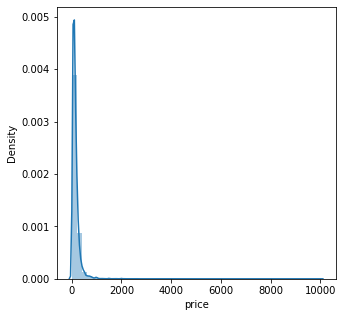

In [ ]:
import seaborn as sns
#Distribution of Price

plt.figure(figsize= (5, 5))
sns.distplot(df_price_check['price'])

In [ ]:
##Plot locations with heatmap intensity as per the Price of the properties
import folium
from folium import plugins

m = folium.Map()
sw = df_price_check[['latitude', 'longitude']].min().values.tolist()
ne = df_price_check[['latitude', 'longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(df_price_check['latitude'], df_price_check['longitude'], df_price_check['price']), radius = 8))
m.fit_bounds([sw, ne])
m

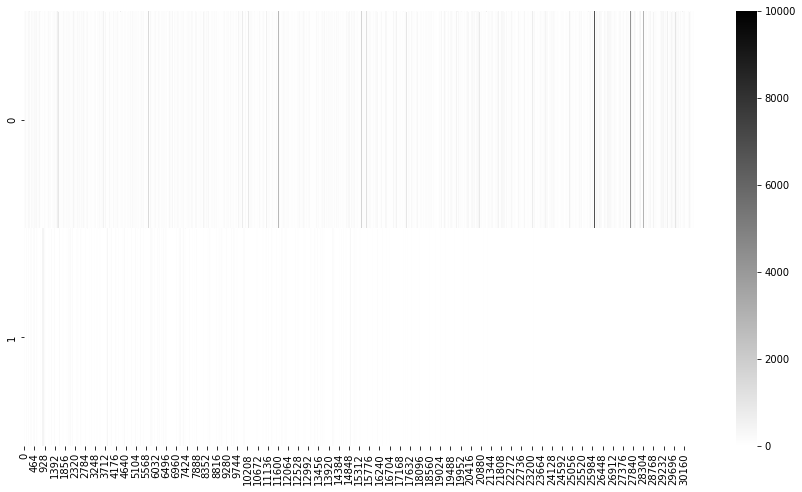

In [ ]:
##Average price of a property

plt.figure(figsize=(15, 8))
cross = ((df_price_check['price']) , df_price_check['number_of_reviews'])
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

In [ ]:
df_price_check = df_price_check.rename(columns={'neighbourhood_group' : "NYC_Boroughs"})

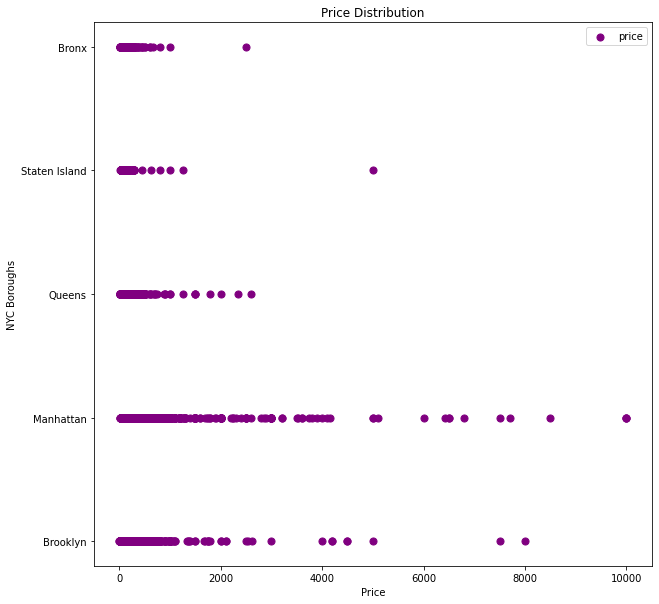

In [ ]:
#Plotting a chart to show the price distribution based on the NYC boroughs

def plot_scatter_chart(df_price_check):
    plt.rcParams['figure.figsize'] = (10,10)
    plt.scatter(df_price_check.price,df_price_check.NYC_Boroughs,color='purple',label='price', s=50)
    plt.xlabel("Price")
    plt.ylabel("NYC Boroughs")
    plt.title("Price Distribution")
    plt.legend()
plot_scatter_chart(df_price_check)

##**Applying model training with scikit learn - Linear Regression**

##Training the model with number of reviews and price to predict price of properties on AirBnb listings - popularity

In [ ]:
from sklearn import linear_model

regs = linear_model.LinearRegression()
regs.fit(df_price_check[['number_of_reviews']], df_price_check['price'])

LinearRegression()

In [ ]:
#Getting the Coefficient
regs.coef_

array([-0.36454031])

In [ ]:
#Getting the Intercept
regs.intercept_

174.10931736603683

In [ ]:
#Predicting the price of an AirBnb with number of reviews - implying popularity
regs.predict([[4]])

array([172.65115614])

##Training the model with minimum_nights and price to predict price of properties on AirBnb listings - avg price

In [ ]:
from sklearn import linear_model

regs = linear_model.LinearRegression()
regs.fit(df[['minimum_nights']], df['price'])

LinearRegression()

In [ ]:
#Getting the Coefficient
regs.coef_

array([0.5024967])

In [ ]:
#Getting the Intercept
regs.intercept_

148.95084674450146

In [ ]:
#Predicting the price of an AirBnb with minimum nights stay - implying avg price
regs.predict([[4]])

array([150.96083356])

#**Exhaustive Search using Faiss**

**Exhaustive search- Comparing each point to every other point, which will require Linear query time - the size of the dataset**

**Vectorizing the dataset and converting it into a dictionary.**

In [ ]:
airbnb_df = df_price_check['name'].copy()

In [ ]:
airbnb_df2 = airbnb_df.head(5000).copy()

In [ ]:
df_vec = df_price_check.copy()

In [ ]:
# df_vec = df_vec.drop(['id','host_id',NYC_Boroughs, room_type	])
df_vec = df_vec[['latitude', 'longitude', 'price']]

In [ ]:
df_vec2 = df_vec.head(5000).copy()

In [ ]:
numpy_array = np.array(airbnb_df2)

In [ ]:
numpy_array

array(['Clean & quiet apt home by the park', 'Skylit Midtown Castle',
       'THE VILLAGE OF HARLEM....NEW YORK !', ...,
       'Modern Vibrant Large Cozy Bedroom* 正面能量',
       'BRAND NEW 1BD / STEPS CENTRAL PARK!',
       'Share quiet, clean and spacious apt'], dtype=object)

In [ ]:
df_vec2

,latitude,longitude,price
0,40.64749,-73.97237,149
1,40.75362,-73.98377,225
2,40.80902,-73.94190,150
3,40.68514,-73.95976,89
5,40.74767,-73.97500,200
...,...,...,...
8016,40.68678,-73.96044,100
8018,40.57770,-73.93988,45
8020,40.82122,-73.92773,56
8022,40.76877,-73.98460,87


In [ ]:
df_vec2['latitude'] = df_vec2.latitude.values * 1.05 + 1

In [ ]:
df_vec2['longitude'] = df_vec2.longitude.values * 1.05 + 1

In [ ]:
df_vec2['price'] = df_vec2.price.values * 1.05 + 1

In [ ]:
df_vec2

,latitude,longitude,price
0,43.679865,-76.670989,157.45
1,43.791301,-76.682958,237.25
2,43.849471,-76.638995,158.50
3,43.719397,-76.657748,94.45
5,43.785054,-76.673750,211.00
...,...,...,...
8016,43.721119,-76.658462,106.00
8018,43.606585,-76.636874,48.25
8020,43.862281,-76.624117,59.80
8022,43.807209,-76.683830,92.35


In [ ]:
vec = np.array(df_vec2)

In [ ]:
vec

array([[ 43.6798645, -76.6709885, 157.45     ],
       [ 43.791301 , -76.6829585, 237.25     ],
       [ 43.849471 , -76.638995 , 158.5      ],
       ...,
       [ 43.862281 , -76.6241165,  59.8      ],
       [ 43.8072085, -76.68383  ,  92.35     ],
       [ 43.666099 , -76.820939 ,  43.       ]])

Installing **Faiss** library - a library that allows us to quickly search for multimedia documents that are similar to each other 

In [ ]:
!pip install faiss

In [ ]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu
import faiss

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
vectors=np.ascontiguousarray(vec)

In [ ]:
vectors.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [ ]:
vectors = vectors.astype('float32')

In [ ]:
import faiss
faiss.MatrixStats(vectors).comments.split("\n")

['analyzing 5000 vectors of size 3',
 'no NaN or Infs in data',
 'all vectors are distinct',
 'range of L2 norms=[92.3385, 8401.46] (0 null vectors)',
 'matrix contains no 0s',
 'no constant dimensions',
 'no dimension has a too large mean',
 'stddevs per dimension are in [0.0414656 251.17]',
 '']

In [ ]:
index = faiss.IndexFlatL2(vectors.shape[1])
index.add(vectors)

In [ ]:
search_vector = vectors[90:91]
distances, indices = index.search(search_vector, 10)

In [ ]:
print(f"The most similar AirBnb to {numpy_array[90]} are:\n")
print([numpy_array[i] for i in indices[0]])

The most similar movies to Monkey Retreat Manhattan are:

['Monkey Retreat Manhattan', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Cozy Harlem Experience', 'Cozy  and sunny room in Manhattan', 'Small, Cozy, Clean and Modern private room!', 'Spacious very High ceiling place !', 'Great and private place to stay in Manhattan!', 'Convenience & Chill']


In [ ]:
quantizer = faiss.IndexFlatL2(vectors.shape[1])
index = faiss.IndexIVFFlat(quantizer, 
                           vectors.shape[1], 
                           100)               # search_in_x_partitions
index.train(vectors)
index.add(vectors)

In [ ]:
search_vector = vectors[90:91]

In [ ]:
 distances, indices = index.search(search_vector, 5)

In [ ]:
print(f"The most similar Airbnb Properties to {numpy_array[90]} are:\n")
print([numpy_array[i] for i in indices[0]])

The most similar movies to Monkey Retreat Manhattan are:

['Monkey Retreat Manhattan', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Cozy Harlem Experience']


### 📣 The most similar AirBnb Properties to Monkey Retreat Manhattan are:

['Monkey Retreat Manhattan', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Cozy Harlem Experience']

#**Vector Encoding using Product Quantization**
**Quantization is a technique to reduce dataset size (from linear) by defining a function (quantizer) that encodes our data into a compact approximated representation**

**Here we can reduce the size of the dataset by replacing every vector with a leaner approximated representation of the vectors (using quantizer) in the encoding phase.**

In [ ]:
quantizer = faiss.IndexFlatL2(vectors.shape[1])
index = faiss.IndexIVFPQ(quantizer, 
                         vectors.shape[1], 
                         100,             # number_of_partition,
                         3,               # search_in_x_partitions, 
                         6)               # subvector_size
index.train(vectors)
index.add(vectors)

In [ ]:
search_vector = vectors[90:91]
distances, indices = index.search(search_vector, 10)

In [ ]:
print(f"The most similar AirBnb to {numpy_array[90]} are:\n")
print([numpy_array[i] for i in indices[0]])

The most similar movies to Monkey Retreat Manhattan are:

['Monkey Retreat Manhattan', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'Budget/diamond in heart of Harlem', 'Spacious very High ceiling place !', 'Cozy  and sunny room in Manhattan', 'Cozy Harlem Experience', 'Convenience & Chill', 'Small, Cozy, Clean and Modern private room!']


### 📣  The most similar AirBnb to Monkey Retreat Manhattan are:

['Monkey Retreat Manhattan', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'Budget/diamond in heart of Harlem', 'Spacious very High ceiling place !', 'Cozy  and sunny room in Manhattan', 'Cozy Harlem Experience', 'Convenience & Chill', 'Small, Cozy, Clean and Modern private room

#**Vector Encoding Using LSH**
**In order to construct the index, we apply multiple hash functions to map data points into buckets so that data points near each other are located in the same buckets with high probability, while data points far from each other are likely to fall into different buckets.**

In [ ]:
class LSHIndex():
  def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
   
  def build(self, num_bits=8):
        self.index = faiss.IndexLSH(self.dimension, num_bits)
        self.index.add(self.vectors)

  def query(self, vectors, k=10):
        distances, indices = self.index.search(vectors, k) 
        # I expect only query on one vector thus the slice
        return [self.labels[i] for i in indices[0]]

In [ ]:
index = LSHIndex(vectors,numpy_array)
index.build()

In [ ]:
index.query(vectors)

['Modern 1 BR / NYC / EAST VILLAGE',
 'BEST BET IN HARLEM',
 'Country space in the city',
 'THE VILLAGE OF HARLEM....NEW YORK !',
 'Cute & Cozy Lower East Side 1 bdrm',
 'Entire apartment in central Brooklyn neighborhood.',
 'Cozy 1BD on Central Park West in New York City',
 'Greenpoint Place...Has It All! ',
 'Midtown Pied-a-terre',
 'Clean & quiet apt home by the park']

# **Vector Encoding Using Trees**
**This constructs forests- a collection of trees, as their data structure by splitting the dataset into subsets. This methos is implemented using the best solution out there, popularly used by Spotify -  Annoy** 


In [ ]:
!pip install annoy

     |████████████████████████████████| 646 kB 8.8 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391681 sha256=740b34cadb6b9d6c1f4ed7621f296a8446dd371d150b0f5a8e58db5ec030e7ee
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [ ]:
from annoy import AnnoyIndex
class AnnoyIndex12():
    def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
   
    def build(self, number_of_trees=5):
        self.index = AnnoyIndex(self.dimension,'angular')
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=10):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=100)                                           
        return [self.labels[i] for i in indices]

In [ ]:
index = AnnoyIndex12(vectors, numpy_array)
index.build()

In [ ]:
index.query(vectors[0])

['Clean & quiet apt home by the park',
 'Beautiful Ft. Greene Apartment-NEW!',
 'Sunny Clinton Hill Apt w/Patio',
 'Stylish,Sunny, spacious luxury loft',
 'Wow!  Two Bedroom Apartment in Safe Neighborhood!',
 'Super cool and sunny apartment in Crown Heights',
 'Gorgeous Room in Heart of Soho',
 'Spacious, Renovated 1 BR Loft Apt',
 'Newly Furnished Beautiful & Quiet',
 'ARTIST TRENDY NYC LOFT']

### 📣 Using Vector Encoding Trees method the most similar properties to 'Clean & quiet apt home by the park' property are:
 'Beautiful Ft. Greene Apartment-NEW!',
 'Sunny Clinton Hill Apt w/Patio',
 'Stylish,Sunny, spacious luxury loft',
 'Wow!  Two Bedroom Apartment in Safe Neighborhood!',
 'Super cool and sunny apartment in Crown Heights',
 'Gorgeous Room in Heart of Soho',
 'Spacious, Renovated 1 BR Loft Apt',
 'Newly Furnished Beautiful & Quiet',
 'ARTIST TRENDY NYC LOFT'

#**Hierarchical Navigable Small World Graphs**
**Created an index class by defining NMSLIB index class with the Airbnb datasets**

**Installed the nmslib library which is cross platform similarity search library**

In [ ]:
vectors

array([[ 43.679863, -76.67099 , 157.45    ],
       [ 43.7913  , -76.68296 , 237.25    ],
       [ 43.849472, -76.63899 , 158.5     ],
       ...,
       [ 43.86228 , -76.624115,  59.8     ],
       [ 43.80721 , -76.68383 ,  92.35    ],
       [ 43.6661  , -76.82094 ,  43.      ]], dtype=float32)

In [ ]:
numpy_array

array(['Clean & quiet apt home by the park', 'Skylit Midtown Castle',
       'THE VILLAGE OF HARLEM....NEW YORK !', ...,
       'Modern Vibrant Large Cozy Bedroom* 正面能量',
       'BRAND NEW 1BD / STEPS CENTRAL PARK!',
       'Share quiet, clean and spacious apt'], dtype=object)

In [ ]:
pip install nmslib

     |████████████████████████████████| 13.5 MB 7.0 MB/s 
     |████████████████████████████████| 188 kB 57.2 MB/s 


In [ ]:
import nmslib
class NMSLIBIndex():
    def __init__(self, vectors, labels):
        self.dimention = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels
    def build(self):
        self.index = nmslib.init(method='hnsw', space='cosinesimil')
        self.index.addDataPointBatch(self.vectors)
        self.index.createIndex({'post': 2})
        
    def query(self, vector, k=10):
        indices = self.index.knnQuery(vector, k=k)
        return [self.labels[i] for i in indices[0]]

In [ ]:
index = NMSLIBIndex(vectors, numpy_array)
index.build()

In [ ]:
index.query(vectors[5])

['Sexy Bedroom near Central Park!',
 'A room w/ a Manhattan view, longer stay',
 'cozy tucked away in el barrio',
 'Cozy Room in LIC, 7 min to Times Sq',
 'Prime location near Central Park !!',
 "Large Furnished Room Near B'way ",
 'Cute Room in Historic Loft!',
 'Spacious Private Bedroom Brooklyn - Williamsburg',
 'DESIGNER LOFT W PRIVATE ROOFTOP & PANORAMIC VIEWS',
 'Williamsburg, prime loction, Brooklyn private room']

### 📣 The nearest neighbour or the most similar properties to "Bedroom near Central Park!" are the following

 'A room w/ a Manhattan view, longer stay',
 'cozy tucked away in el barrio',
 'Cozy Room in LIC, 7 min to Times Sq',
 'Prime location near Central Park !!',
 "Large Furnished Room Near B'way ",
 'Cute Room in Historic Loft!',
 'Spacious Private Bedroom Brooklyn - Williamsburg',
 'DESIGNER LOFT W PRIVATE ROOFTOP & PANORAMIC VIEWS',
 'Williamsburg, prime loction, Brooklyn private room'